In [1]:
import numpy as np
import seaborn, math, os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit, least_squares
from copy import deepcopy
import scipy.stats as stats

C:\Anaconda\envs\py34\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%matplotlib notebook
plt.style.use('seaborn-notebook')

In [3]:
np.set_printoptions(precision=3, suppress=True)

In [4]:
%run medidas_biodiversidad.py

In [5]:
def calcular_riqueza(datos, paisajes, bio_min = 5.):
    riquezas = np.zeros((40, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            riquezas[comunidad, intensificacion] = riqueza_agricola(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)[1]
    return riquezas

In [6]:
def calcular_sw(datos, paisajes, bio_min = 5.):
    riquezas = np.zeros((40, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            riquezas[comunidad, intensificacion] = shannon_wiener(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return riquezas

In [7]:
def calcular_biomasa(datos, paisajes, bio_min = 5.):
    biomasas = np.zeros((40, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            biomasas[comunidad, intensificacion] = riqueza_agricola(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)[0]
            
    return biomasas

In [8]:
def calcular_promedio(riquezas):
    """Recibe datos de riqueza.
    """
    promedios = np.zeros(10)
    std = np.zeros(10)
    for i in range(10):
        promedios[i] = np.mean(riquezas[riquezas[:, 0]>=0, i]) #Por qué >=???
        std[i] = np.std(riquezas[:, i])
    return promedios, std

In [9]:
def calcular_prueba(datos, paisajes, bio_min = 5.):
    riquezas = np.zeros((40, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            riquezas[comunidad, intensificacion] = medida_prueba(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return riquezas

In [10]:
paisajes = [None] * 5
for het in range(5):
    paisajes[het] = np.load("paisajes_h{}.npy".format(het))

In [11]:
datos = [None] * 2

files = os.listdir("./datos/exp2")
files.sort()
datos[0] = [np.load("./datos/exp2/" + file) for file in files]

files = os.listdir("./datos/exp1")
files.sort()
files = list(filter(lambda x: x[6] == "2", files))
datos[1] = [np.load("./datos/exp1/" + file) for file in files]
comunidad = [file[9:12] for file in files]

In [12]:
riquezas = [None] * 2
sw = [None] * 2
biomasas = [None] * 2
prueba = [None] * 2
riquezas_mean = [None] * 2
riquezas_sd = [None] * 2
biomasas_mean = [None] * 2
biomasas_sd = [None] * 2
sw_mean = [None] * 2
sw_sd = [None] * 2

prueba_mean = [None] * 2
prueba_sd = [None] * 2



for k in range(2):
    riquezas[k] = calcular_riqueza(datos[k], paisajes[2], bio_min = 5)
    riquezas_mean[k], riquezas_sd[k] = calcular_promedio(riquezas[k])
    sw[k] = calcular_sw(datos[k], paisajes[2], bio_min = 5)
    sw_mean[k], sw_sd[k]  = calcular_promedio(sw[k])
    biomasas[k] = calcular_biomasa(datos[k], paisajes[2], bio_min = 5)
    
    #normalizar biomasas:
    
    for i in range(len(biomasas[k])):
        biomasas[k][i] = biomasas[k][i] / biomasas[k][i, 0]    
    
    biomasas_mean[k], biomasas_sd[k] = calcular_promedio(biomasas[k])
    
    prueba[k] = calcular_prueba(datos[k], paisajes[2], bio_min = 5)
    prueba_mean[k], prueba_sd[k] = calcular_promedio(prueba[k])

C:\Anaconda\envs\py34\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<IPython.core.display.Javascript object>


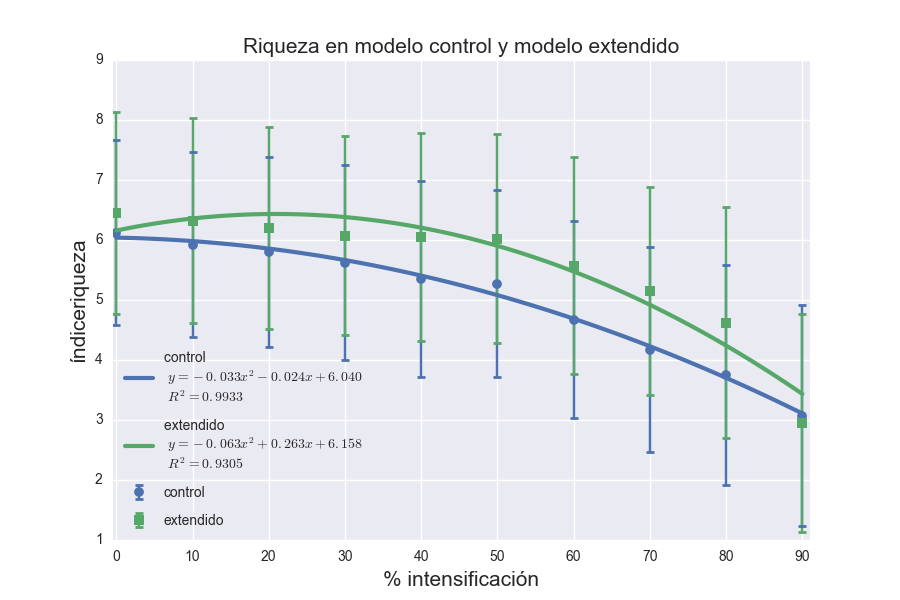

In [31]:
# Graficar
%matplotlib notebook
plt.style.use('seaborn-notebook')
seaborn.set_palette("deep", color_codes=True)

promedios = prueba_mean
sd = prueba_sd

y = [None] * 2
res = [None] * 2
p = [None] * 2
r2 = [None] * 2

x = np.linspace(0, 9, 100)
xdata = np.array(range(10))
xlabels = np.array(range(10)) * 10 

ylabels=["control", "extendido"]
puntos= ["o", "s"]
colors = ['b', 'g']

for k in range(2):
    res[k] = np.polyfit(xdata, promedios[k], 2, w=sd[k])
    p[k] = np.poly1d(res[k])
    r2[k] = 1 - ((np.sum((p[k](range(10)) - promedios[k])**2)) / (np.sum((promedios[k] - np.mean(promedios[k]))**2)))
        
fig = plt.figure(figsize=(9, 6), dpi = 100)

for k in range(2):
    y[k] = p[k](x)
    #plt.plot(xdata, promedios[k], 'o') #data points
    plt.plot(x, y[k], lw = 3, color = colors[k], label='{} \n $y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                            ylabels[k], float(p[k][2]), float(p[k][1]), float(p[k][0]), float(r2[k]))) #fit
    #plt.errorbar(xdata, promedios[k], yerr=sd[k], fmt=puntos[k], label='{}'.format(ylabels[k]), color = colors[k])
    plt.errorbar(xdata, promedios[k], capsize = 3, yerr=sd[k], fmt=puntos[k], label='{}'.format(ylabels[k]), color = colors[k],
                 capthick=2)

#plt.ylim(-0.05, 10)
plt.xlim(-0.05, 9.1)
plt.xticks(xdata, xlabels)
plt.xlabel("% intensificación", size = 15)
plt.ylabel("índiceriqueza", size = 15)
#plt.yscale("log")
plt.title("Riqueza en modelo control y modelo extendido", size = 15)
plt.legend(loc='best', fontsize = "small", labelspacing=1)
plt.show()

In [13]:
#¿Cuántas comunidades no tuvieron cambios en niveles de intensificación?
#riquezas = np.array(riquezas)
count = 0
for k in range(1):
    for c in range(40):
        if riquezas[k, c, 0] == riquezas[k, c, 8]:
            count += 1

TypeError: list indices must be integers, not tuple

In [14]:
#Biomasa: Graficar promedios con curva ajustada ponderada
%matplotlib notebook
seaborn.color_palette("husl", 6)
xdata = np.array(range(10))
labels = np.array(range(10)) * 10
res = [None] * 5
p = [None] * 5

for het in range(5):
    res[het] = np.polyfit(xdata, promedios_b[het], 2, w=sd_b[het])
    p[het] = np.poly1d(res[het])

fig = plt.figure()
x = np.linspace(0, 9, 100)
y = [None] * 5

for het in range(5):
    y[het] = p[het](x)
    #plt.plot(xdata, promedios[het], 'o', label='{}'.format(het))
    plt.plot(x, y[het], label='{}'.format(het))

#plt.ylim(0, 10)
plt.xticks(xdata, labels)
plt.xlabel("% intensificación")
plt.ylabel("biomasa")
plt.title("bio_min = 20")
plt.legend(loc='best', title="het")
plt.show()

NameError: name 'promedios_b' is not defined

### Intentando Anova

In [21]:
# shape: [het, comunidades, intensificación]
riquezas = np.array(riquezas)
biomasas = np.array(biomasas)
prueba = np.array(prueba)

In [ ]:
riquezas[:, :, 0]

In [ ]:
df = pandas.DataFrame(riquezas[:, :, 0], columns=list(np.array(range(40))))

In [ ]:
df = df.T

In [ ]:
i = 0
stats.f_oneway(riquezas[0, :, i],
               riquezas[1, :, i])

In [ ]:
i = 9
anova = stats.f_oneway(riquezas[0, :, i],
                       riquezas[1, :, i])
ttest = stats.ttest_ind(riquezas[0, :, i],
                        riquezas[1, :, i], equal_var=False)
print(anova)
print(ttest)

In [ ]:
# Esto no
nivel = 
ttest = np.zeros([5, 5, 2])
for i in range(5):
    for j in range(5):
        #print(i, j)
        ttest[i, j] = stats.ttest_ind(riquezas[i, :, nivel],riquezas[j, :, nivel], equal_var=False)       

In [22]:
# ¿En qué niveles de intensificación hay una diferencia significativa entre h1 y h0?
for n in range(10):
    ttest = stats.ttest_ind(prueba[0, :, n],
                            prueba[1, :, n], equal_var=False)
    print("nivel {}:  ".format(n), ttest[0], ttest[1])

nivel 0:   -0.889461364886 0.376514197086
nivel 1:   -1.08621494952 0.280765470128
nivel 2:   -1.08302000481 0.282146738002
nivel 3:   -1.20891897156 0.230348156632
nivel 4:   -1.83504792337 0.0703229777141
nivel 5:   -2.0019401414 0.0488062933961
nivel 6:   -2.30152182801 0.0240529899782
nivel 7:   -2.50211520017 0.0144390725147
nivel 8:   -2.05481661499 0.0432556552305
nivel 9:   0.302329941693 0.763205371356


In [ ]:
fig = plt.figure()
plt.hist(riquezas[0, :, 9])
plt.hist(riquezas[4, :, 9])
#plt.ylim(0, 10)
#plt.xlim(0, 9)
plt.show()

In [ ]:
het = 1
ttest2 = stats.f_oneway(riquezas[het, :, 0],
                         riquezas[het, :, 1],
                         riquezas[het, :, 2],
                         riquezas[het, :, 3],
                         riquezas[het, :, 4],
                         riquezas[het, :, 5],
                         riquezas[het, :, 6],
                         riquezas[het, :, 7],
                         riquezas[het, :, 8],
                         riquezas[het, :, 9])
ttest2

Anterior:

In [ ]:
#normalizar riquezas
riquezas_norm = deepcopy(riquezas)
for i in range(len(riquezas)):
    if riquezas[i, 0] >= 4:
        riquezas_norm[i] = riquezas_norm[i] / riquezas[i, 0]
    else:
        riquezas_norm[i] = 0

In [ ]:
def sigmoid(x, A, K, B, v, Q, C):
    y = A + (K - A)/((C + Q*np.exp(-B*x))**(1./v))
    return y

def exp_decay(x, y0, λ):
    ln_y = np.log(y0) - λ*x
    return ln_y

In [ ]:
# Fit a 2 polynomial to every community
riquezasb = deepcopy(riquezas[1,:,:])
%matplotlib notebook
seaborn.color_palette("husl", 6)
xdata = np.array(range(10))
labels = np.array(range(10)) * 10
res = [None] * 40
p = [None] * 40

for c in range(40):
    res[c] = np.polyfit(xdata, riquezasb[c, :], 2)
    p[c] = np.poly1d(res[c])

fig = plt.figure()
x = np.linspace(0, 9, 100)
y = [None] * 40

for c in range(40):
    y[c] = p[c](x)
    #plt.plot(xdata, riquezasb[c, :], 'o', label='{}'.format(c))
    plt.plot(x, y[c], label='{}'.format(c))

#plt.ylim(0, 10)
plt.xticks(xdata, labels)
plt.xlabel("% intensificación")
plt.ylabel("riquezas")
plt.title("comunidades 0")
#plt.legend(loc='best', title="c")
plt.show()

In [ ]:
riquezasb = deepcopy(riquezas[0,:,:])
xdata = np.array(range(10))
all_y = []
for i in range(len(riquezasb)):
    if riquezasb[i, 0] >= 4:
        #print(i)
        ydata = riquezasb[i, :]
        try:
            popt, pcov = curve_fit(sigmoid, xdata, ydata, 
                               p0=(9, 7, 2, 2, 5000, 0.02), bounds = (0, np.inf))
        except RuntimeError:
            pass
        all_y.append(popt)
all_y = np.array(all_y)

In [ ]:
#%matplotlib inline
fig = plt.figure()
x = np.linspace(0, 9, 100)
for popt in all_y:
    y = sigmoid(x, *popt)
    #plt.plot(xdata, ydata, 'o', label='data')
    plt.plot(x,y)
plt.ylim(0, 10)
#plt.legend(loc='best')
plt.show()

In [ ]:
perr = np.sqrt(np.diag(pcov))

In [ ]:
%matplotlib inline
df = pandas.DataFrame(riquezas[riquezas[:, 0]>=0], columns=list(np.array(range(10)) * 10))

fig = plt.figure(figsize=(15, 8))
seaborn.violinplot(df[df.loc[:, 0]>0], bw = 0.2)
#seaborn.violinplot(df)

plt.show() 

In [ ]:
# Execute this cell to load the notebook's style sheet, then ignore it
# Original de numericalmooc, por Lorena Barba
from IPython.core.display import HTML
css_file = "C:/Users/hp\Desktop/proyectof/style2.css"
HTML(open(css_file, "r").read())